In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings
from matplotlib.pyplot import figure
import seaborn as sns
from pmdarima import auto_arima
warnings.filterwarnings('ignore')

In [18]:
df = pd.read_csv('Kiriwaneliya_multivariate.csv',parse_dates=['Time'], index_col='Time')
df.head()

,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Power
Time,,,,,,
2013-01-01,158.400001,10.6,19.9,76.6,87.8,524501
2013-02-01,141.700002,10.3,20.1,78.6,88.7,460880
2013-03-01,153.400001,11.5,21.7,78.4,90.1,519945
2013-04-01,102.899999,11.4,23.1,74.8,90.4,452010
2013-05-01,148.500000,14.0,21.4,85.4,95.0,1487403


In [19]:
#Checking for missing values
df.isna().sum()

Rainfall    5
Temp_min    1
Temp_max    1
Hum_min     2
Hum_max     3
Power       0
dtype: int64

In [20]:
df=df.resample('MS').first()

In [21]:
#removing missing values
df=df.fillna(method='ffill')
df.head()

,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Power
Time,,,,,,
2013-01-01,158.400001,10.6,19.9,76.6,87.8,524501
2013-02-01,141.700002,10.3,20.1,78.6,88.7,460880
2013-03-01,153.400001,11.5,21.7,78.4,90.1,519945
2013-04-01,102.899999,11.4,23.1,74.8,90.4,452010
2013-05-01,148.500000,14.0,21.4,85.4,95.0,1487403


In [22]:
df=df[['Temp_min','Temp_max','Hum_min','Hum_max','Rainfall']]

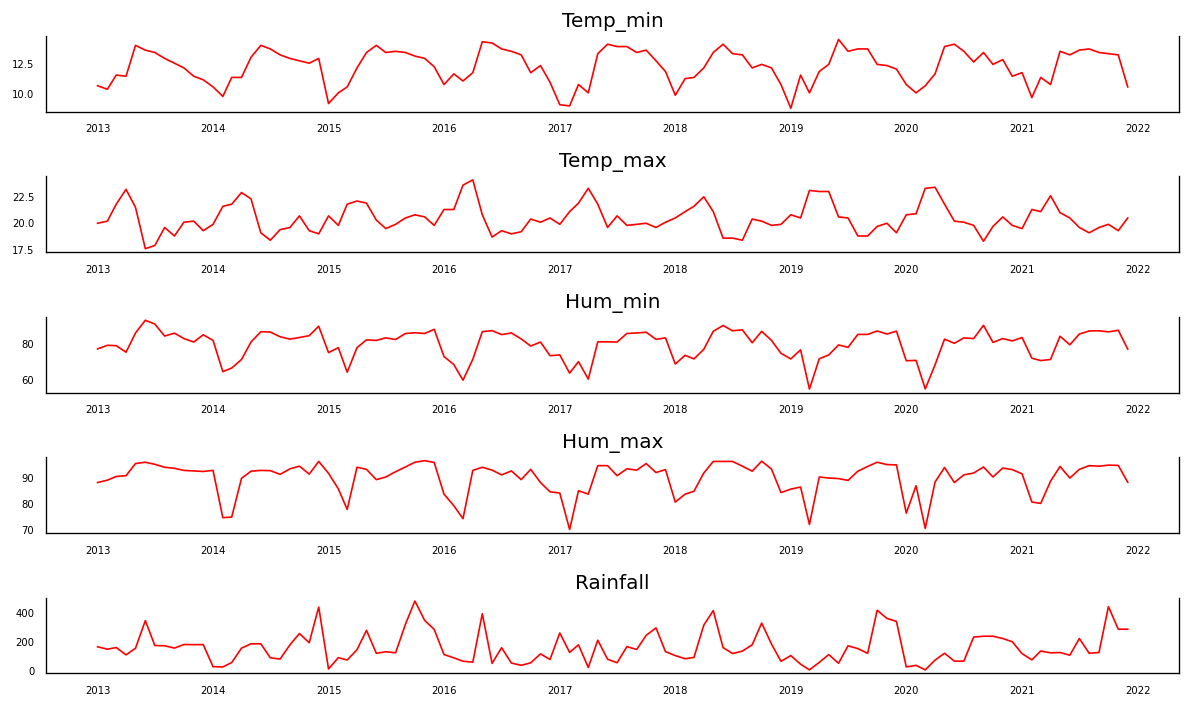

In [23]:
fig, axes = plt.subplots(nrows=5, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

    H0: Series is not stationary
    H1: Series is Stationary

In [24]:
### ADF Test
col=df.columns
for i in range(len(col)):
    test_result=adfuller(df[col[i]])
    def adfuller_test(x):
        result=adfuller(x)
        labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
        for value,label in zip(result,labels):
            print(label+' : '+str(value) )
        if result[1] <= 0.05:
            print("strong evidence against the null hypothesis(Ho), reject the null hypothesis.Therefore, "+col[i]+" series is stationary")
        else:
            print("weak evidence against null hypothesis, time series has a unit root, indicating " + col[i] + " series is non-stationary ")

    adfuller_test(df[col[i]])

ADF Test Statistic : -3.2469521555223997
p-value : 0.01742276511774096
#Lags Used : 13
Number of Observations Used : 94
strong evidence against the null hypothesis(Ho), reject the null hypothesis.Therefore, Temp_min series is stationary
ADF Test Statistic : -2.8555424178590143
p-value : 0.050767443722477865
#Lags Used : 13
Number of Observations Used : 94
weak evidence against null hypothesis, time series has a unit root, indicating Temp_max series is non-stationary 
ADF Test Statistic : -2.722324353912577
p-value : 0.07025420627685001
#Lags Used : 13
Number of Observations Used : 94
weak evidence against null hypothesis, time series has a unit root, indicating Hum_min series is non-stationary 
ADF Test Statistic : -2.7125816041802953
p-value : 0.0718862919489686
#Lags Used : 13
Number of Observations Used : 94
weak evidence against null hypothesis, time series has a unit root, indicating Hum_max series is non-stationary 
ADF Test Statistic : -4.974341467799573
p-value : 2.493984529927

#### According to the ADF test, Temp max,Hum_min, and Hum_max non-stationary. Therefore it needs to difference the series.

In [25]:
ad_fuller_result_1 = adfuller(df['Temp_max'].diff()[1:])

print('Temp_max')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

Temp_max
ADF Statistic: -10.905126801282968
p-value: 1.1332160113236713e-19


In [26]:
ad_fuller_result_2 = adfuller(df['Hum_min'].diff()[1:])

print('Hum_min')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

Hum_min
ADF Statistic: -4.212070006963741
p-value: 0.0006285785089541569


In [27]:
ad_fuller_result_4 = adfuller(df['Hum_max'].diff()[1:])

print('Hum_max')
print(f'ADF Statistic: {ad_fuller_result_4[0]}')
print(f'p-value: {ad_fuller_result_4[1]}')

Hum_max
ADF Statistic: -4.504889925585532
p-value: 0.00019267777457451123


In [28]:
#Combine first differenced Temp_min with rest.
df['Temp_max']=df['Temp_max'].diff()[1:]
df['Hum_min']=df['Hum_min'].diff()[1:]
df['Hum_max']=df['Hum_max'].diff()[1:]
#df= df.iloc[1: , :] #Remioving the first column
#Checking for missing values
df.isna().sum()

Temp_min    0
Temp_max    1
Hum_min     1
Hum_max     1
Rainfall    0
dtype: int64

In [29]:
#removing missing values
df=df.dropna(how="any")
df.head()

,Temp_min,Temp_max,Hum_min,Hum_max,Rainfall
Time,,,,,
2013-02-01,10.3,0.2,2.0,0.9,141.700002
2013-03-01,11.5,1.6,-0.2,1.4,153.400001
2013-04-01,11.4,1.4,-3.6,0.3,102.899999
2013-05-01,14.0,-1.7,10.6,4.6,148.500000
2013-06-01,13.6,-3.9,7.0,0.5,337.800001


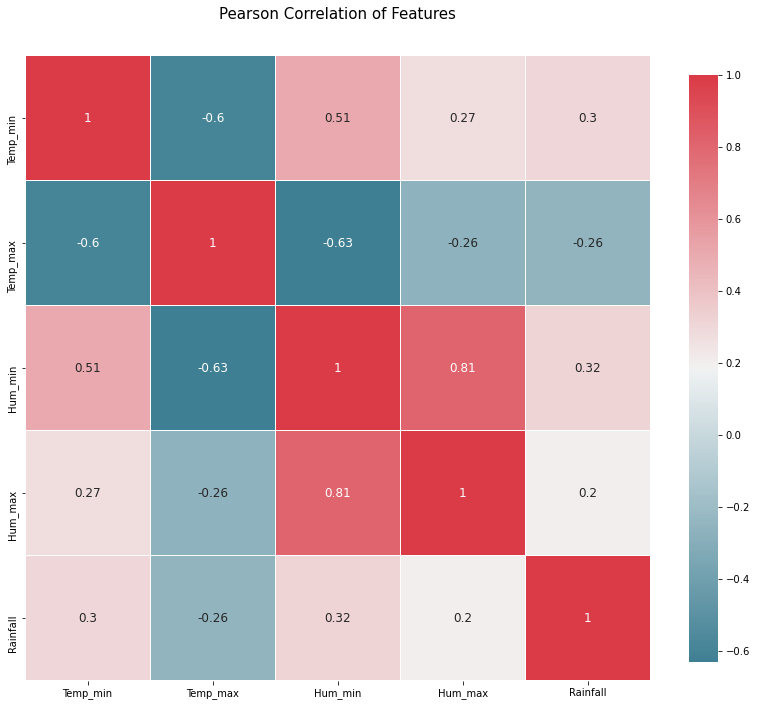

In [30]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(df)

# Fitting ARIMAX model

In [31]:
#Re-importing dataset without setting the index on time axis.
df_1 = pd.read_csv('Denawaka_multivariate.csv')
#Removing first row
df_2= df_1.iloc[1: , :]
#Remove Temp_min, Temp_max column
df_2=df_2.drop(columns=['Temp_max','Hum_min','Hum_max'])

#Concat the dataframe with first differenced Temp_min with first row removed dataframe
df=pd.concat([df_2,df_1['Temp_max'].diff()[1:],df_1['Hum_min'].diff()[1:],df_1['Hum_max'].diff()[1:]],axis=1)
#removing missing values
df=df.dropna(how="any")
df.head()

,Rainfall,Temp_min,Time,Power,Temp_max,Hum_min,Hum_max
1,228.3,22.5,2013-February,1094607,1.6,-3.0,0.0
2,319.2,23.1,2013-March,2145374,0.5,5.0,3.0
3,280.6,24.1,2013-April,4632494,0.3,-1.0,0.0
4,492.3,24.5,2013-May,2567256,-2.8,7.0,-2.0
5,542.8,23.7,2013-June,4305650,-1.4,1.0,-2.0


### Feature Engineering

In [32]:
def feature_engineering(data):
    data['Time'] = pd.to_datetime(data['Time'])
    data["Time"] = pd.to_datetime(data["Time"], format="%Y-%m-%d")
    data["year"] = data["Time"].dt.year
    data["month"] = data["Time"].dt.month
    
    lag_features = ["Rainfall","Temp_min","Temp_max","Hum_min","Hum_max"]
    window1 = 2
    window2 = 3
    window3 = 7

    data_rolled_2d = data[lag_features].rolling(window=window1, min_periods=0)
    data_rolled_3d = data[lag_features].rolling(window=window2, min_periods=0)
    data_rolled_7d = data[lag_features].rolling(window=window3, min_periods=0)

    data_mean_2d = data_rolled_2d.mean().shift(1)
    data_mean_3d = data_rolled_3d.mean().shift(1)
    data_mean_7d = data_rolled_7d.mean().shift(1)
    
    data_std_2d = data_rolled_2d.std().shift(1)
    data_std_3d = data_rolled_3d.std().shift(1)
    data_std_7d = data_rolled_7d.std().shift(1)

    for feature in lag_features:
        data[f"{feature}_mean_lag{window1}"] = data_mean_2d[feature]
        data[f"{feature}_mean_lag{window2}"] = data_mean_3d[feature]
        data[f"{feature}_mean_lag{window3}"] = data_mean_7d[feature]

        data[f"{feature}_std_lag{window1}"] = data_std_2d[feature]
        data[f"{feature}_std_lag{window2}"] = data_std_3d[feature]
        data[f"{feature}_std_lag{window3}"] = data_std_7d[feature]

    data.fillna(data.mean(), inplace=True)
    
feature_engineering(df)

In [33]:
df.head()

,Rainfall,Temp_min,Time,Power,Temp_max,Hum_min,Hum_max,year,month,Rainfall_mean_lag2,...,Hum_min_mean_lag7,Hum_min_std_lag2,Hum_min_std_lag3,Hum_min_std_lag7,Hum_max_mean_lag2,Hum_max_mean_lag3,Hum_max_mean_lag7,Hum_max_std_lag2,Hum_max_std_lag3,Hum_max_std_lag7
1,228.3,22.5,2013-02-01,1094607,1.6,-3.0,0.0,2013,2,313.544624,...,-0.041321,4.104294,4.558866,5.160665,-0.075269,-0.073477,-0.094444,2.444130,2.789910,3.086767
2,319.2,23.1,2013-03-01,2145374,0.5,5.0,3.0,2013,3,228.300000,...,-3.000000,4.104294,4.558866,5.160665,0.000000,0.000000,0.000000,2.444130,2.789910,3.086767
3,280.6,24.1,2013-04-01,4632494,0.3,-1.0,0.0,2013,4,273.750000,...,1.000000,5.656854,5.656854,5.656854,1.500000,1.500000,1.500000,2.121320,2.121320,2.121320
4,492.3,24.5,2013-05-01,2567256,-2.8,7.0,-2.0,2013,5,299.900000,...,0.333333,4.242641,4.163332,4.163332,1.500000,1.000000,1.000000,2.121320,1.732051,1.732051
5,542.8,23.7,2013-06-01,4305650,-1.4,1.0,-2.0,2013,6,386.450000,...,2.000000,5.656854,4.163332,4.760952,-1.000000,0.333333,0.250000,1.414214,2.516611,2.061553


In [34]:
#Checking for missing values
df.isnull().sum()

Rainfall              0
Temp_min              0
Time                  0
Power                 0
Temp_max              0
Hum_min               0
Hum_max               0
year                  0
month                 0
Rainfall_mean_lag2    0
Rainfall_mean_lag3    0
Rainfall_mean_lag7    0
Rainfall_std_lag2     0
Rainfall_std_lag3     0
Rainfall_std_lag7     0
Temp_min_mean_lag2    0
Temp_min_mean_lag3    0
Temp_min_mean_lag7    0
Temp_min_std_lag2     0
Temp_min_std_lag3     0
Temp_min_std_lag7     0
Temp_max_mean_lag2    0
Temp_max_mean_lag3    0
Temp_max_mean_lag7    0
Temp_max_std_lag2     0
Temp_max_std_lag3     0
Temp_max_std_lag7     0
Hum_min_mean_lag2     0
Hum_min_mean_lag3     0
Hum_min_mean_lag7     0
Hum_min_std_lag2      0
Hum_min_std_lag3      0
Hum_min_std_lag7      0
Hum_max_mean_lag2     0
Hum_max_mean_lag3     0
Hum_max_mean_lag7     0
Hum_max_std_lag2      0
Hum_max_std_lag3      0
Hum_max_std_lag7      0
dtype: int64

In [35]:
#Splitting the data set to train and test
train=df[:int(0.67*(len(df)))]
valid=df[int(0.67*(len(df))):]

In [36]:
features=df.columns
print(features)

Index(['Rainfall', 'Temp_min', 'Time', 'Power', 'Temp_max', 'Hum_min',
       'Hum_max', 'year', 'month', 'Rainfall_mean_lag2', 'Rainfall_mean_lag3',
       'Rainfall_mean_lag7', 'Rainfall_std_lag2', 'Rainfall_std_lag3',
       'Rainfall_std_lag7', 'Temp_min_mean_lag2', 'Temp_min_mean_lag3',
       'Temp_min_mean_lag7', 'Temp_min_std_lag2', 'Temp_min_std_lag3',
       'Temp_min_std_lag7', 'Temp_max_mean_lag2', 'Temp_max_mean_lag3',
       'Temp_max_mean_lag7', 'Temp_max_std_lag2', 'Temp_max_std_lag3',
       'Temp_max_std_lag7', 'Hum_min_mean_lag2', 'Hum_min_mean_lag3',
       'Hum_min_mean_lag7', 'Hum_min_std_lag2', 'Hum_min_std_lag3',
       'Hum_min_std_lag7', 'Hum_max_mean_lag2', 'Hum_max_mean_lag3',
       'Hum_max_mean_lag7', 'Hum_max_std_lag2', 'Hum_max_std_lag3',
       'Hum_max_std_lag7'],
      dtype='object')


In [37]:
#Removing predictor variable and time column
features=[ 'Temp_min','Temp_max', 'Hum_min',
       'Hum_max','Rainfall_mean_lag2', 'Rainfall_mean_lag3',
       'Rainfall_mean_lag7', 'Rainfall_std_lag2', 'Rainfall_std_lag3',
       'Rainfall_std_lag7', 'Temp_min_mean_lag2', 'Temp_min_mean_lag3',
       'Temp_min_mean_lag7', 'Temp_min_std_lag2', 'Temp_min_std_lag3',
       'Temp_min_std_lag7', 'Temp_max_mean_lag2', 'Temp_max_mean_lag3',
       'Temp_max_mean_lag7', 'Temp_max_std_lag2', 'Temp_max_std_lag3',
       'Temp_max_std_lag7', 'Hum_min_mean_lag2', 'Hum_min_mean_lag3',
       'Hum_min_mean_lag7', 'Hum_min_std_lag2', 'Hum_min_std_lag3',
       'Hum_min_std_lag7', 'Hum_max_mean_lag2', 'Hum_max_mean_lag3',
       'Hum_max_mean_lag7', 'Hum_max_std_lag2', 'Hum_max_std_lag3',
       'Hum_max_std_lag7']

In [49]:
arimaxmodel = auto_arima(train['Rainfall'],
                   exogenous = train[features], trace=True, 
                   error_action="ignore", suppress_warnings=True,stepwise=False,max_d=2,max_D=2,m=12,max_p=6,max_q=6,maxiter=100,max_order=None,alpha=0.05,
                        information_criterion='aic',out_of_sample_size=int(len(train)*0.2),method='powell')
arimaxmodel.fit(train['Rainfall'], exogenous = train[features])
# model = arima()
arimaxforecast = arimaxmodel.predict(n_periods=len(valid), exogenous = valid[features])
valid["Forecast_ARIMAX"] = arimaxforecast

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=844.390, Time=2.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=10.70 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=inf, Time=52.41 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=838.553, Time=8.24 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=17.91 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=39.13 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=859.532, Time=70.98 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=140.56 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=126.52 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=7.00 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=18.77 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=46.22 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=16.15 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=19.35 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=51.62 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=8

KeyboardInterrupt: 

In [50]:
arimaxmodel.summary()

NameError: name 'arimaxmodel' is not defined

Text(0.5, 1.0, 'Rainfall Forecasting')

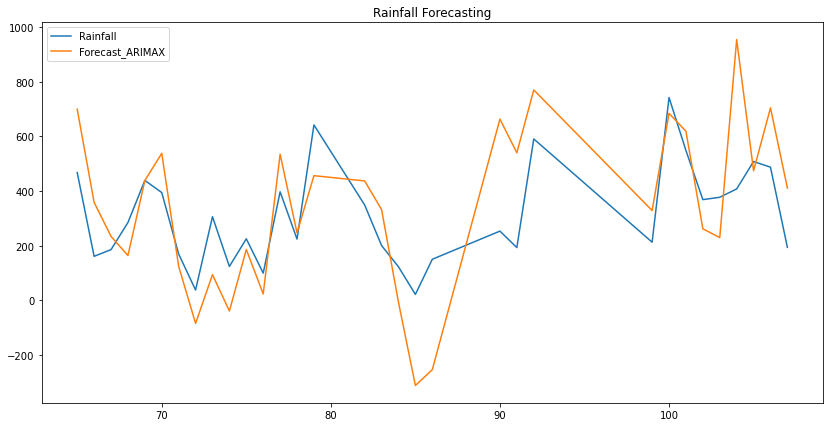

In [48]:
#Forecast using built model
valid[["Rainfall", "Forecast_ARIMAX"]].plot(figsize=(14, 7))
plt.title('Rainfall Forecasting')